## Домашнее задание : "Обучение с подкреплением"

# Задание 1

Обучите алгоритм Q-learning для сред FrozenLake-v1 и Blackjack-v1, в частности подберите оптимальную alpha. (1 балл)

In [ ]:
!pip install gym
!pip install "gym[toy_text]"
!pip install "gym[atari]"
!pip install "autorom[accept-rom-license]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 1.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 28.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441028 sha256=6201799c85e90024a6ab1f7996d40bc11d646ce1ac0c0fef73836bf3fe731d79
  Stored in directory: /root/.cache/pip/wheels/51/08/c5/28b973078691a3f8baf99fcaec1ed8f0e05ef6e54d2390212c
Successfully built AutoROM.accept-rom-license


In [ ]:
import random, os

import gym
import numpy as np

import matplotlib.pyplot as plt

from collections import defaultdict

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam

from torch.distributions.categorical import Categorical

import torchvision.transforms as transforms

torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.device(device)

def seed_everything(seed):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
seed_everything(42)

In [82]:
def train_policy(Q, alpha, environment, n_iters=1000):
    for _ in range(n_iters):
        state = environment.reset()
        done = False
        
        while not done:
            action = np.argmax(Q[state]) if np.max(Q[state]) > 0 else environment.action_space.sample()
            
            new_state, reward, done, _ = environment.step(action)
            
            Q[state][action] = (1 - alpha) * Q[state][action] + alpha * (reward + np.max(Q[new_state]))
            
            state = new_state

In [84]:
def evaluate_policy(Q, environment, n_iters=1000):
    total = 0
    for _ in range(n_iters):
        state = environment.reset()
        done = False

        while not done:
            action = np.argmax(Q[state]) if np.max(Q[state]) > 0 else environment.action_space.sample()
            
            new_state, reward, done, _ = environment.step(action)
                    
            state = new_state
            
            total += reward
    return total/n_iters

In [85]:
environment = gym.make("FrozenLake-v1", is_slippery=False)

alphas = np.arange(0, 1.1, 0.05)

best_alpha = -1
best_iters = 1200

# среда очень простая, должна получиться Q дающая 100% прохождений
# пусть оптимальная альфа такая, что сходимость наступает быстрее всего  
for alpha in alphas:
    Q = defaultdict(lambda: np.zeros(environment.action_space.n))
    
    iters_scores = []
    
    for n_iters in range(100, 1001, 100):
        train_policy(Q, alpha, environment, n_iters)
        
        # считаем что сошлось если за 1000 итераций скор 1.0, 
        # т.е. все запуски привели к награде
        score = evaluate_policy(Q, environment, 1000)

        iters_scores.append([n_iters, score])
        
    iters_scores = np.array(iters_scores)
    mask = np.where(iters_scores[:, 1] == 1.0)[0]
    
    if len(mask) == 0:
        continue
    
    iters = iters_scores[np.where(iters_scores[:, 1] == 1.0)].min(axis=0)[0]
    if iters < best_iters:
        best_iters = iters
        best_alpha = alpha
        
print(best_alpha, best_iters)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


0.2 100.0


In [86]:
environment = gym.make("Blackjack-v1")

alphas = np.arange(0, 1.1, 0.05)

best_alpha = -1
best_score = -1

# тут трудно говорить что-то о сходимости к 100% винрейту,
# поэтому пусть оптимальная альфа такая, что сумма наград 
# наибольшая за одинаковое число итераций (100к)
for alpha in alphas:
    Q = defaultdict(lambda: np.zeros(environment.action_space.n))
    
    train_policy(Q, alpha, environment, 100000)
    
    score = evaluate_policy(Q, environment, 1000)

    if score > best_score:
        best_score = score
        best_alpha = alpha
        
print(best_alpha, best_score)

0.9 -0.064


# Задание 2

Обучите алгоритм Policy Gradients (или Actor Critic) для среды https://www.gymlibrary.dev/environments/atari/breakout/ . Продемонстрируйте, что для обученного агента растет время игры. (2 балла)

In [ ]:
class Policy(nn.Module):
    def __init__(self, num_actions, device):
        super().__init__()

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(),
            transforms.CenterCrop((175,150)),
            transforms.Resize((84, 84)),
            transforms.ToTensor()
        ])

        self.num_actions = num_actions

        self.conv1 = nn.Conv2d(1, 32, 8, stride=4, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)

        self.maxpool = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten(1)
        
        self.linear1 = nn.Linear(64, 256)
        self.linear2 = nn.Linear(256, num_actions)
        
        self.relu = torch.nn.ReLU(inplace=True)
        self.softmax = torch.nn.Softmax(dim=1)

        self.device = device

    def forward(self, x):
        x = self.relu(self.maxpool(self.conv1(x)))
        x = self.relu(self.maxpool(self.conv2(x)))
        x = self.relu(self.maxpool(self.conv3(x)))


        x = self.flatten(x)

        x = self.relu(self.linear1(x))
        out = self.softmax(self.linear2(x))
        return out
    
    def get_action(self, state):
        state = torch.tensor(state).float() / 255.0
        state = state.permute(2, 0, 1) # -> (3, 210, 160)
        state = self.transform(state)
        state = state.unsqueeze(0) # -> (1, 3, 210, 160)
        state = Variable(state)
        state = state.to(self.device)

        probs = self.forward(state)

        action_sample = Categorical(probs.squeeze(0)).sample()

        log_prob = torch.log(probs.squeeze(0)[action_sample])
        return action_sample, log_prob

In [ ]:
def update_policy(optimizer, rewards, log_probs, gamma=0.9):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        for pow, r in enumerate(rewards[t:]):
            Gt = Gt + gamma**pow * r
        discounted_rewards.append(Gt)
        
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) 
    
    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    
    optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    optimizer.step()

In [77]:
environment = gym.make('ALE/Breakout-v5', render_mode="rgb_array")
policy = Policy(environment.action_space.n, device).to(device)
optimizer = Adam(policy.parameters(), lr=1e-4)

# если мячик падает, то списывается 1 жизнь. всего 5 жизней
# когда они кончаются игра прекращается (становится done)

# соотв попробуем поучить максимум на 10000 шагов 
# т.е. игра принудительно завершается если удалось прожить столько

# и итераций запуска 2000. Чем лучше агент умеет играть, 
# тем дольше он живёт и тем дольше длится итерация,
# что можно отследить по прогрес бару tqdm и если что 
# заинтерраптить выполнение ячейки

max_episode_num = 2000
max_steps = 10000
numsteps = []
avg_numsteps = []
all_rewards = []

for episode in tqdm(range(max_episode_num)):
    state = environment.reset()
    log_probs = []
    rewards = []

    for steps in range(max_steps):
        action, log_prob = policy.get_action(state)
        new_state, reward, done, _ = environment.step(action)
        log_probs.append(log_prob)
        rewards.append(reward)

        if done:
            update_policy(optimizer, rewards, log_probs)
            numsteps.append(steps)
            avg_numsteps.append(np.mean(numsteps[-10:]))
            all_rewards.append(np.sum(rewards))
            break
        
        state = new_state

100%|██████████| 2000/2000 [28:39<00:00,  1.16it/s]


(число ходов до вылета, среднее за 10 последних игр)
последние попытки: [248.4, 255.4, 258.0, 253.1, 243.1]
первые попытки: [133.0, 157.5, 151.66666666666666, 157.25, 168.2]
(набранные очки)
последние попытки: [7.0, 11.0, 7.0, 3.0, 0.0]
первые попытки: [0.0, 1.0, 0.0, 1.0, 2.0]


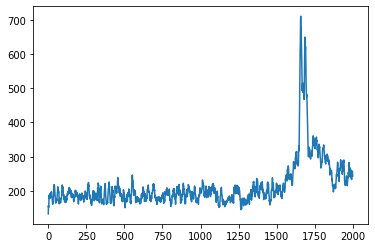

In [78]:
print("(число ходов до вылета, среднее за 10 последних игр)")
print("последние попытки:", avg_numsteps[-5:])

print("первые попытки:", avg_numsteps[:5])
print("(набранные очки)")
print("последние попытки:", all_rewards[-5:])

print("первые попытки:", all_rewards[:5])

plt.plot(avg_numsteps)
plt.show()

Начинает набирать очки и живёт дольше

In [81]:
torch.save(policy, "policy")